In [4]:
import os
import cv2
import glob
from math import atan2, asin
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from torch.utils.data import DataLoader, Dataset, sampler
from torch.optim.lr_scheduler import ReduceLROnPlateau
import albumentations as aug
from albumentations import (HorizontalFlip, RandomResizedCrop, VerticalFlip,OneOf, ShiftScaleRotate, Normalize, Resize, Compose,Cutout, GaussNoise, RandomRotate90, Transpose, RandomBrightnessContrast, RandomCrop)
from albumentations import ElasticTransform, GridDistortion, OpticalDistortion, Blur, RandomGamma
from albumentations.pytorch import ToTensor
import torch
from torchvision import transforms
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
import torch.backends.cudnn as cudnn
import torchvision.models as models
import time
import random
import scipy.io
import random
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score, recall_score, precision_score
import sys
sys.path.insert(0, 'segmentation_models.pytorch/')
import segmentation_models_pytorch as smp
skf = StratifiedKFold(n_splits=5, shuffle = True, random_state=24)
try:
    from ralamb import Ralamb
    from radam import RAdam
    from ranger import Ranger
    from lookahead import LookaheadAdam
    from over9000 import Over9000
    from tqdm.notebook import tqdm
except:
    os.system(f"""git clone https://github.com/mgrankin/over9000.git""")
    import sys
    sys.path.insert(0, 'over9000/')
    from ralamb import Ralamb
    from radam import RAdam
    from ranger import Ranger
    from lookahead import LookaheadAdam
    from over9000 import Over9000
    from tqdm.notebook import tqdm

#### Setting Random Seed

In [5]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything(24)

##### Training and validation split was created while keeping the distribution of the classes(Covid/Not-Covid) similar, for better evaluation 

In [6]:
df = pd.read_csv('df_covid.csv')
df_train = pd.read_csv('df_train.csv')
df_val = pd.read_csv('df_val.csv')
print(f"Total Size: {len(df)}, Train Size: {len(df_train)}, Val Size: {len(df_val)}")

Total Size: 544, Train Size: 435, Val Size: 109


## Visualisation
#### Clearly the distribution of train and val split is same

In [4]:
def checkDistribution(df, phase):
    df['Covid'].value_counts().sort_index().plot(kind="bar", figsize=(4,3), rot = 0) 
    if phase == 'train':        
        plt.title("Label Distribution (Training Set)", 
                  weight='bold', 
                  fontsize=10)
    else:
        plt.title("Label Distribution (Validation Set)", 
                  weight='bold', 
                  fontsize=10)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.xlabel("Label", fontsize=10)
    plt.ylabel("Frequency", fontsize=10);

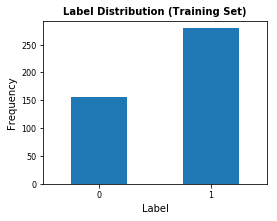

In [5]:
checkDistribution(df_train, 'train')

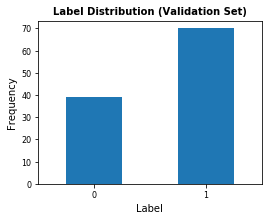

In [6]:
checkDistribution(df_val, 'val')

In [7]:
def plot(path):
    w=10
    h=10
    fig=plt.figure(figsize=(8, 8))
    columns = 4
    rows = 5
    for i in range(1, columns*rows +1):
        if(path[i][-3:]=='png'):
            img = cv2.imread(path[i])
        else:
            print(path[i])
        fig.add_subplot(rows, columns, i)
        plt.imshow(img)
    plt.show()

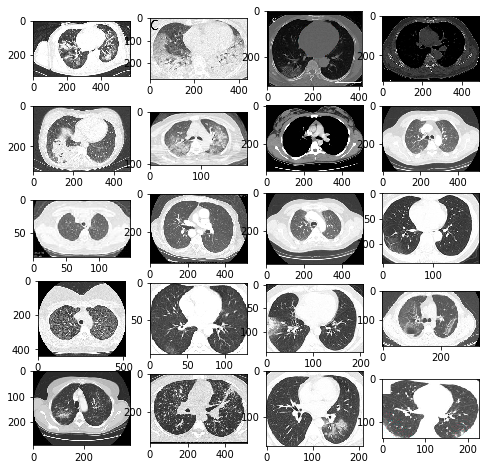

In [69]:
path = list(df.Path)
plot(path)

### Checking for corrupt images

In [71]:
count=0
for i in range(len(df.Path)):
    try:
        image = cv2.imread(df.loc[i].Path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (224, 224))
    except:
        print(i)
        df.drop(i, inplace = True)
        count+=1

### Class for Dataset

In [7]:
class Covid_Dataset(Dataset):
    def __init__(self, df, phase='train', transform =True):
        self.df = df
        self.phase = phase
        self.aug = get_transforms(self.phase)
        self.transform = transform
    def __getitem__(self,idx):
        image = cv2.imread(self.df.loc[idx].Path)
        image = cv2.resize(image, (256, 256), interpolation = cv2.INTER_NEAREST)
        label = self.df.loc[idx].Covid
        label = np.asarray(label).reshape(1,)
        augment = self.aug(image =image)
        image = augment['image']       
        return image,label
    def __len__(self):
        return len(self.df)

In [8]:
def get_transforms(phase):
    """
        This function returns the transformation list.
        These are some commonly used augmentation techniques that 
        I believed would be useful.
    """
    list_transforms = []
    if phase == "train":
        list_transforms.extend(
            [
             HorizontalFlip(p = 0.5),
             VerticalFlip(p = 0.5),
            
            Cutout(num_holes=4, p=0.5),
            ShiftScaleRotate(p=1,border_mode=cv2.BORDER_CONSTANT),
#             OneOf([
#             ElasticTransform(p=0.1, alpha=1, sigma=50, alpha_affine=50,border_mode=cv2.BORDER_CONSTANT),
#             GridDistortion(distort_limit =0.05 ,border_mode=cv2.BORDER_CONSTANT, p=0.1),
#             OpticalDistortion(p=0.1, distort_limit= 0.05, shift_limit=0.2,border_mode=cv2.BORDER_CONSTANT)                  
#             ], p=0.3),
#              OneOf([
#             Blur(blur_limit=7)
#             ], p=0.4),    
#             RandomGamma(p=0.8)
        ]
      )
    list_transforms.extend(
        [
#             RandomResizedCrop(height = 224, width = 224, p = 1),
#             Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225], p=1),
            ToTensor(),
        ]
    )
    list_trfms = Compose(list_transforms)
    return list_trfms

### This function returns the dataloader according to the phase(training/validation)

In [9]:
def provider(phase,batch_size=16, num_workers=0):
    """
        This function returns the dataloader according to 
        the phase passed.
    """
    
    if phase == 'train' :
        df = pd.read_csv('df_train.csv')
        image_dataset = Covid_Dataset(df)
    else:
        df = pd.read_csv('df_val.csv')
        image_dataset = Covid_Dataset(df, transform = False)
    dataloader = DataLoader(
        image_dataset,
        batch_size=batch_size,
        num_workers=0,
        pin_memory=False,
        shuffle=True,   
    )
    return dataloader

## Code to check if DataLoader is working properly or not

torch.Size([16, 3, 256, 256])
torch.Size([16, 1])


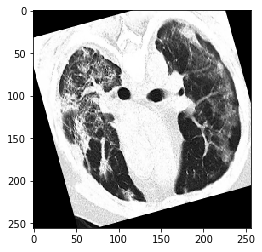

tensor([[1],
        [0],
        [1],
        [1],
        [1],
        [1],
        [1],
        [0],
        [1],
        [1],
        [0],
        [1],
        [0],
        [1],
        [0],
        [1]])


In [7]:
dl = provider('train')
for x, y in dl:
    print(x.shape)
    print(y.shape)
    x = x[0].permute(1,2,0).cpu().numpy()
    plt.imshow(x)
    plt.show()
    print(y)
    break

### Meter to create log file for training

In [49]:
class Meter:
    '''A meter to keep track of iou and dice scores throughout an epoch'''
    def __init__(self, phase, epoch):
        self.acc_scores = []
        self.f1_scores = []
        self.precision_scores = []
        self.recall_scores = []
        self.phase = phase

    def update(self, targets, outputs):
        probs = torch.sigmoid(outputs)
        probs_cls = torch.sigmoid(outputs)
        precision = precision_score(targets, probs_cls.round(), labels = [0,1])
        recall = recall_score(targets, probs_cls.round(), labels = [0,1])
        f1 = f1_score(targets, probs_cls.round(), labels = [0,1])
        acc = accuracy_score(targets, probs_cls.round())
        # Adding all metrics to list
        self.acc_scores.append(acc)
        self.f1_scores.append(f1)
        self.precision_scores.append(precision)
        self.recall_scores.append(recall)

    def get_metrics(self):
        acc = np.nanmean(self.acc_scores)
        f1 = np.nanmean(self.f1_scores)
        precision = np.nanmean(self.precision_scores)
        recall = np.nanmean(self.recall_scores)
        return acc, f1, precision, recall
    
def epoch_log(phase, epoch, epoch_loss, meter, start):
    '''logging the metrics at the end of an epoch'''
    acc, f1, precision, recall = meter.get_metrics()
    print("Loss: %0.4f | accuracy: %0.4f | F1: %0.4f | Precision: %0.4f | Recall: %0.4f" % (epoch_loss, acc, f1, precision, recall))
    return acc, f1, precision, recall

In [50]:
class BCEDiceLoss(nn.Module):
    __name__ = 'bce_dice_loss'

    def __init__(self, eps=1e-7, beta=2., fn_weight = .6,activation='sigmoid', ignore_channels=None, threshold=None):
        super().__init__()
        self.bce = nn.BCEWithLogitsLoss(reduction='mean')
        self.beta = beta
        self.eps = eps
        self.threshold = threshold
        self.ignore_channels = ignore_channels
        self.activation = smp.utils.base.Activation(activation)

    def forward(self, y_pr, y_gt):
        bce = self.bce(y_pr, y_gt)
        y_pr = self.activation(y_pr)
        dice = 1 - smp.utils.functional.f_score(
            y_pr, y_gt,
            beta=self.beta,
            eps=self.eps,
            threshold=self.threshold,
            ignore_channels=self.ignore_channels,
        )
        return dice + bce

In [51]:
class Trainer(object):
    """
        This class takes care of training and validation of our model
    """
    def __init__(self,model, optim, lr, bs, epochs = 20, name = 'model', shape=200):
        self.batch_size = bs
        self.accumulation_steps = 1
        self.lr = lr
        self.name = name
        self.num_epochs = epochs
        self.optim = optim
        self.best_loss = float("inf")
        self.phases = ["train", "val"]
        self.device = torch.device("cuda:0")
        torch.set_default_tensor_type("torch.FloatTensor")
        self.net = model
        self.best_val_acc = 0
        self.best_val_loss = 10
        self.best_f1_score = 0
        self.losses = {phase: [] for phase in self.phases}
        self.criterion = BCEDiceLoss()
        if self.optim == 'Over9000':
            self.optimizer = Over9000(self.net.parameters(),lr=self.lr)
        elif self.optim == 'Adam':
            self.optimizer = torch.optim.Adam(self.net.parameters(),lr=self.lr)
        elif self.optim == 'RAdam':
            self.optimizer = Radam(self.net.parameters(),lr=self.lr)
        elif self.optim == 'Ralamb':
            self.optimizer = Ralamb(self.net.parameters(),lr=self.lr)
        elif self.optim == 'Ranger':
            self.optimizer = Ranger(self.net.parameters(),lr=self.lr)
        elif self.optim == 'LookaheadAdam':
            self.optimizer = LookaheadAdam(self.net.parameters(),lr=self.lr)
        else:
            raise(Exception(f'{self.optim} is not recognized. Please provide a valid optimizer function.'))
            
        self.scheduler = ReduceLROnPlateau(self.optimizer, mode="min", patience=3, verbose=True,factor = 0.5,min_lr = 1e-5)
        self.net = self.net.to(self.device)
        cudnn.benchmark = True
        self.dataloaders = {
            phase: provider(
                phase=phase,
                batch_size=self.batch_size
            )
            for phase in self.phases
        }
        self.losses = {phase: [] for phase in self.phases}
        self.acc_scores = {phase: [] for phase in self.phases}
        self.f1_scores = {phase: [] for phase in self.phases}
    
        def load_model(self, name, path='models/'):
            state = torch.load(path+name, map_location=lambda storage, loc: storage)
            self.net.load_state_dict(state['state_dict'])
            self.optimizer.load_state_dict(state['optimizer'])
            print("Loaded model with dice: ", state['best_acc'])
    
    def forward(self, images, targets):
        images = images.to(self.device)
        targets = targets.type("torch.FloatTensor")
        targets = targets.to(self.device)
        preds = self.net(images)
        preds.to(self.device)
        loss = self.criterion(preds,targets)
        # Calculating accuracy of the predictions
#         probs = torch.sigmoid(preds)
#         probs_cls = torch.sigmoid(preds)
#         acc = accuracy_score(probs_cls.detach().cpu().round(), targets.detach().cpu())
        return loss, preds

    def iterate(self, epoch, phase):
        meter = Meter(phase, epoch)
        start = time.strftime("%H:%M:%S")
        print(f"Starting epoch: {epoch} | phase: {phase} | ⏰: {start}")
        batch_size = self.batch_size
        self.net.train(phase == "train")
        dataloader = self.dataloaders[phase]
        running_loss = 0.0
        total_batches = len(dataloader)
        tk0 = tqdm(dataloader, total=total_batches)
        self.optimizer.zero_grad()
        for itr, batch in enumerate(tk0): 
            images, targets = batch
            loss, preds= self.forward(images, targets)
            loss = loss / self.accumulation_steps
            if phase == "train":
                loss.backward()
                if (itr + 1 ) % self.accumulation_steps == 0:
                    self.optimizer.step()
                    self.optimizer.zero_grad()
            running_loss += loss.item()
            preds = preds.detach().cpu()
            targets = targets.detach().cpu()
            meter.update(targets, preds)
            tk0.set_postfix(loss=(running_loss / ((itr + 1))))
        epoch_loss = (running_loss * self.accumulation_steps) / total_batches
        acc, f1, precision, recall = epoch_log(phase, epoch, epoch_loss, meter, start)
        self.losses[phase].append(epoch_loss)
        self.acc_scores[phase].append(acc)
        torch.cuda.empty_cache()
        return epoch_loss, acc, f1, precision, recall

    def train_end(self):
        train_loss = self.losses["train"]
        val_loss = self.losses["val"]
        train_acc = self.acc_scores["train"]
        val_acc = self.acc_scores["val"]
        df_data=np.array([train_loss, train_acc, val_loss, val_acc]).T
        df = pd.DataFrame(df_data,columns = ['train_loss','train_acc', 'val_loss', 'val_acc'])
        df.to_csv('logs/'+self.name+".csv")
        
    def predict(self):
        self.net.eval()
        with torch.no_grad():
            self.iterate(1,'test')
        print('Done')

    def fit(self, epochs):
#         self.num_epochs+=epochs
        for epoch in range(0, self.num_epochs):
            self.iterate(epoch, "train")
            state = {
                "epoch": epoch,
                "best_loss": self.best_val_loss,
                "best_f1": self.best_f1_score,
                "state_dict": self.net.state_dict(),
                "optimizer": self.optimizer.state_dict(),
            }
            self.net.eval()
            with torch.no_grad():
                epoch_loss, acc, f1, precision, recall = self.iterate(epoch, "val")
                self.scheduler.step(epoch_loss)
            if f1 >  self.best_f1_score:
                print("* New optimal found according to f1 score, saving state *")
                state["best_f1"] = self.best_f1_score = f1
                os.makedirs('models/', exist_ok=True)
                torch.save(state, 'models/'+self.name+'_best_f1.pth')
            if epoch_loss <  self.best_val_loss:
                print("* New optimal found according to val loss, saving state *")
                state["best_loss"] = self.best_val_loss = epoch_loss
                os.makedirs('models/', exist_ok=True)
                torch.save(state, 'models/'+self.name+'_best_loss.pth')
            print()
            self.train_end()

### Create Model and start training

In [52]:
try:
    from efficientnet_pytorch import EfficientNet
except:
    os.system(f"""pip install efficientnet-pytorch""")
    from efficientnet_pytorch import EfficientNet
model = EfficientNet.from_pretrained('efficientnet-b3')
num_ftrs = model._fc.in_features
model._fc = nn.Linear(num_ftrs, 1)

Loaded pretrained weights for efficientnet-b3


In [53]:
model_trainer = Trainer(model, optim='Over9000',bs=32, lr=1e-3, name='b3-model-1-Over9000')
model_trainer.do_cutmix = False
model_trainer.fit(20)

Starting epoch: 0 | phase: train | ⏰: 20:53:29



Loss: 1.1592 | accuracy: 0.5242 | F1: 0.6182 | Precision: 0.6300 | Recall: 0.6145
Starting epoch: 0 | phase: val | ⏰: 20:53:40



Loss: 1.1912 | accuracy: 0.4549 | F1: 0.3267 | Precision: 0.7917 | Recall: 0.2216
* New optimal found according to f1 score, saving state *
* New optimal found according to val loss, saving state *

Starting epoch: 1 | phase: train | ⏰: 20:53:44



Loss: 1.1111 | accuracy: 0.6574 | F1: 0.7494 | Precision: 0.7023 | Recall: 0.8119
Starting epoch: 1 | phase: val | ⏰: 20:53:56



Loss: 1.1512 | accuracy: 0.6028 | F1: 0.5952 | Precision: 0.8586 | Recall: 0.4729
* New optimal found according to f1 score, saving state *
* New optimal found according to val loss, saving state *

Starting epoch: 2 | phase: train | ⏰: 20:54:00



Loss: 1.0340 | accuracy: 0.7617 | F1: 0.8316 | Precision: 0.7620 | Recall: 0.9210
Starting epoch: 2 | phase: val | ⏰: 20:54:12



Loss: 1.1297 | accuracy: 0.6076 | F1: 0.6339 | Precision: 0.8526 | Recall: 0.5307
* New optimal found according to f1 score, saving state *
* New optimal found according to val loss, saving state *

Starting epoch: 3 | phase: train | ⏰: 20:54:16



Loss: 0.9625 | accuracy: 0.7782 | F1: 0.8426 | Precision: 0.7732 | Recall: 0.9440
Starting epoch: 3 | phase: val | ⏰: 20:54:27



Loss: 1.0677 | accuracy: 0.7626 | F1: 0.7802 | Precision: 0.9246 | Recall: 0.6825
* New optimal found according to f1 score, saving state *
* New optimal found according to val loss, saving state *

Starting epoch: 4 | phase: train | ⏰: 20:54:31



Loss: 0.8347 | accuracy: 0.8318 | F1: 0.8785 | Precision: 0.8054 | Recall: 0.9753
Starting epoch: 4 | phase: val | ⏰: 20:54:43



Loss: 0.9945 | accuracy: 0.7933 | F1: 0.8156 | Precision: 0.9388 | Recall: 0.7287
* New optimal found according to f1 score, saving state *
* New optimal found according to val loss, saving state *

Starting epoch: 5 | phase: train | ⏰: 20:54:47



Loss: 0.6996 | accuracy: 0.8749 | F1: 0.9059 | Precision: 0.8676 | Recall: 0.9532
Starting epoch: 5 | phase: val | ⏰: 20:54:59



Loss: 0.9553 | accuracy: 0.7981 | F1: 0.8223 | Precision: 0.9510 | Recall: 0.7367
* New optimal found according to f1 score, saving state *
* New optimal found according to val loss, saving state *

Starting epoch: 6 | phase: train | ⏰: 20:55:03



Loss: 0.5661 | accuracy: 0.8929 | F1: 0.9154 | Precision: 0.8970 | Recall: 0.9432
Starting epoch: 6 | phase: val | ⏰: 20:55:14



Loss: 0.8493 | accuracy: 0.8209 | F1: 0.8458 | Precision: 0.9521 | Recall: 0.7674
* New optimal found according to f1 score, saving state *
* New optimal found according to val loss, saving state *

Starting epoch: 7 | phase: train | ⏰: 20:55:18



Loss: 0.4416 | accuracy: 0.9322 | F1: 0.9477 | Precision: 0.9559 | Recall: 0.9427
Starting epoch: 7 | phase: val | ⏰: 20:55:30



Loss: 0.8185 | accuracy: 0.7746 | F1: 0.7971 | Precision: 0.9653 | Recall: 0.6837
* New optimal found according to val loss, saving state *

Starting epoch: 8 | phase: train | ⏰: 20:55:33



Loss: 0.3517 | accuracy: 0.9353 | F1: 0.9484 | Precision: 0.9498 | Recall: 0.9491
Starting epoch: 8 | phase: val | ⏰: 20:55:44



Loss: 0.7588 | accuracy: 0.8017 | F1: 0.8008 | Precision: 0.9080 | Recall: 0.7176
* New optimal found according to val loss, saving state *

Starting epoch: 9 | phase: train | ⏰: 20:55:47



Loss: 0.2743 | accuracy: 0.9554 | F1: 0.9638 | Precision: 0.9700 | Recall: 0.9586
Starting epoch: 9 | phase: val | ⏰: 20:55:59



Loss: 0.7226 | accuracy: 0.7782 | F1: 0.8115 | Precision: 0.9427 | Recall: 0.7192
* New optimal found according to val loss, saving state *

Starting epoch: 10 | phase: train | ⏰: 20:56:01



Loss: 0.2509 | accuracy: 0.9561 | F1: 0.9666 | Precision: 0.9810 | Recall: 0.9542
Starting epoch: 10 | phase: val | ⏰: 20:56:13



Loss: 0.5996 | accuracy: 0.8558 | F1: 0.8757 | Precision: 0.9535 | Recall: 0.8144
* New optimal found according to f1 score, saving state *
* New optimal found according to val loss, saving state *

Starting epoch: 11 | phase: train | ⏰: 20:56:17



Loss: 0.1976 | accuracy: 0.9665 | F1: 0.9715 | Precision: 0.9621 | Recall: 0.9844
Starting epoch: 11 | phase: val | ⏰: 20:56:29



Loss: 0.5349 | accuracy: 0.8636 | F1: 0.8814 | Precision: 0.9844 | Recall: 0.8003
* New optimal found according to f1 score, saving state *
* New optimal found according to val loss, saving state *

Starting epoch: 12 | phase: train | ⏰: 20:56:32



Loss: 0.1720 | accuracy: 0.9665 | F1: 0.9733 | Precision: 0.9736 | Recall: 0.9765
Starting epoch: 12 | phase: val | ⏰: 20:56:44



Loss: 0.5915 | accuracy: 0.8365 | F1: 0.8567 | Precision: 0.8945 | Recall: 0.8265

Starting epoch: 13 | phase: train | ⏰: 20:56:45



Loss: 0.1066 | accuracy: 0.9933 | F1: 0.9944 | Precision: 0.9923 | Recall: 0.9968
Starting epoch: 13 | phase: val | ⏰: 20:56:57



Loss: 0.5217 | accuracy: 0.8401 | F1: 0.8652 | Precision: 0.9143 | Recall: 0.8211
* New optimal found according to val loss, saving state *

Starting epoch: 14 | phase: train | ⏰: 20:57:00



Loss: 0.0884 | accuracy: 0.9873 | F1: 0.9909 | Precision: 0.9915 | Recall: 0.9908
Starting epoch: 14 | phase: val | ⏰: 20:57:12



Loss: 0.6110 | accuracy: 0.7939 | F1: 0.8250 | Precision: 0.8872 | Recall: 0.8030

Starting epoch: 15 | phase: train | ⏰: 20:57:13



Loss: 0.0908 | accuracy: 0.9844 | F1: 0.9878 | Precision: 0.9862 | Recall: 0.9905
Starting epoch: 15 | phase: val | ⏰: 20:57:24



Loss: 0.5716 | accuracy: 0.8095 | F1: 0.8184 | Precision: 0.9183 | Recall: 0.7402

Starting epoch: 16 | phase: train | ⏰: 20:57:26



Loss: 0.1127 | accuracy: 0.9754 | F1: 0.9799 | Precision: 0.9804 | Recall: 0.9821
Starting epoch: 16 | phase: val | ⏰: 20:57:37



Loss: 0.5410 | accuracy: 0.8450 | F1: 0.8795 | Precision: 0.9171 | Recall: 0.8499

Starting epoch: 17 | phase: train | ⏰: 20:57:38



Loss: 0.0895 | accuracy: 0.9866 | F1: 0.9883 | Precision: 0.9838 | Recall: 0.9943
Starting epoch: 17 | phase: val | ⏰: 20:57:50



Loss: 0.4248 | accuracy: 0.8834 | F1: 0.9089 | Precision: 0.9081 | Recall: 0.9117
* New optimal found according to f1 score, saving state *
* New optimal found according to val loss, saving state *

Starting epoch: 18 | phase: train | ⏰: 20:57:54



Loss: 0.0850 | accuracy: 0.9844 | F1: 0.9896 | Precision: 0.9960 | Recall: 0.9844
Starting epoch: 18 | phase: val | ⏰: 20:58:06



Loss: 0.3475 | accuracy: 0.9183 | F1: 0.9340 | Precision: 0.9314 | Recall: 0.9437
* New optimal found according to f1 score, saving state *
* New optimal found according to val loss, saving state *

Starting epoch: 19 | phase: train | ⏰: 20:58:10



Loss: 0.0724 | accuracy: 0.9844 | F1: 0.9875 | Precision: 0.9849 | Recall: 0.9910
Starting epoch: 19 | phase: val | ⏰: 20:58:22



Loss: 0.3706 | accuracy: 0.9069 | F1: 0.9216 | Precision: 0.9398 | Recall: 0.9063



### Predict and Test

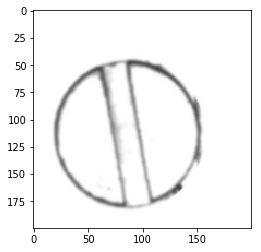

True Label:  0 Predicted Label:  [0]


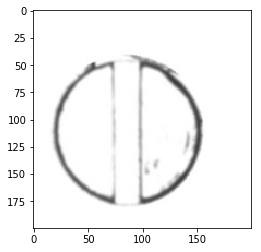

True Label:  0 Predicted Label:  [0]


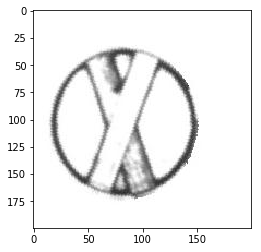

True Label:  1 Predicted Label:  [1]


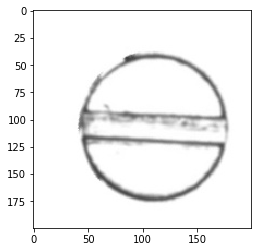

True Label:  0 Predicted Label:  [0]


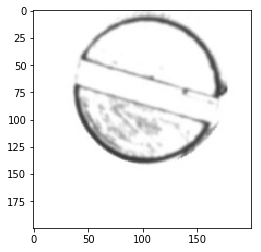

True Label:  0 Predicted Label:  [0]


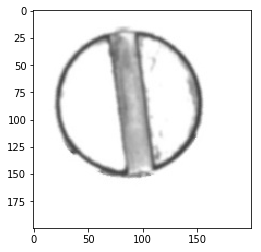

True Label:  0 Predicted Label:  [0]


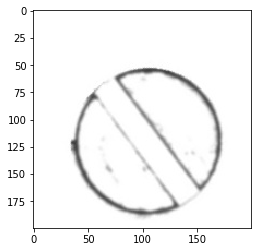

True Label:  0 Predicted Label:  [0]


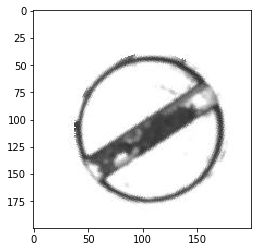

True Label:  1 Predicted Label:  [1]


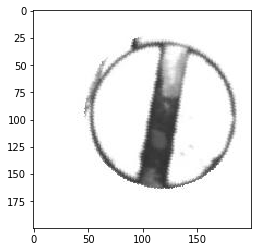

True Label:  1 Predicted Label:  [1]


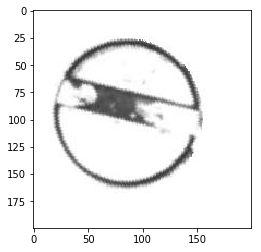

True Label:  1 Predicted Label:  [1]


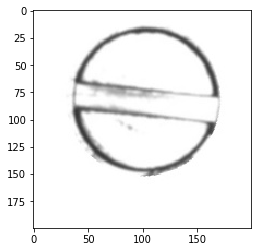

True Label:  0 Predicted Label:  [0]


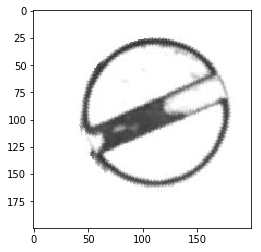

True Label:  1 Predicted Label:  [1]


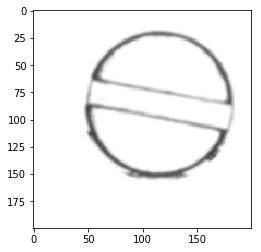

True Label:  0 Predicted Label:  [0]


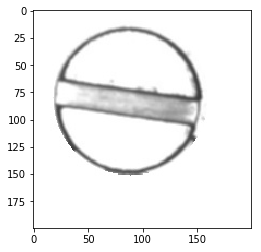

True Label:  0 Predicted Label:  [0]


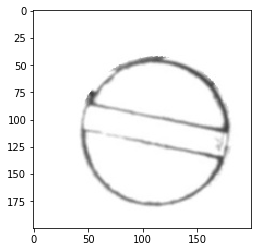

True Label:  0 Predicted Label:  [0]


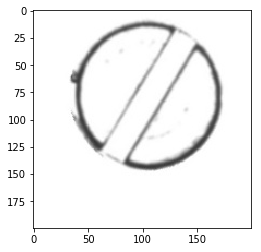

True Label:  0 Predicted Label:  [0]


In [36]:
dl_val = provider('val')
path = "models/b3-model-1_best_loss.pth"
checkpoint = torch.load(path)
model.load_state_dict(checkpoint["state_dict"])
for img, y_true in dl_val:
    y_preds = model(img)
    y_preds = nn.Sigmoid()(y_preds)
    y_preds = y_preds.detach().cpu().numpy()
    y_preds = (y_preds > 0.4).astype('uint8')
    img = img.detach().cpu().permute(0, 2,3,1).numpy()
    for i in range(img.shape[0]):
        image = img[i]
        y_tr = y_true[i].item()
        plt.imshow(image)
        plt.show()
        print("True Label: ", y_tr, "Predicted Label: ", y_preds[i])
    break